# dPb concentrations across the domain for a single depth level

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import pandas as pd
import xarray as xr
import gsw

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
isize = imax - imin
jsize = jmax - jmin

# model results:
year = 2015
results_folder1 = f'/data/brogalla/run_storage/Pb-tuning-202302/Pb-reference-{year}_20230221/'
# results_folder1 = f'/data/brogalla/run_storage/Pb-tuning-202302/Pb-nosedice-{year}_20230221/'

# colors:
c_masked = '#eaeae9'

#### Load files:

In [3]:
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
ANHA12_lon   = mfile['nav_lon'].values
ANHA12_lat   = mfile['nav_lat'].values
tmask        = mfile['tmask'].values
tmask_sub    = mfile['tmask'].values[0,:,imin:imax,jmin:jmax]

mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_bathy   = mesh['hdept'].values[0]
e3t          = mesh['e3t_0'].values[0,:,imin:imax,jmin:jmax]
land_mask    = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 
e3t_masked   = np.ma.masked_where((tmask_sub[:,:,:] < 0.1), e3t)

In [4]:
month  = 8
results     = xr.open_dataset(f'{results_folder1}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month:02}-{year}{month:02}.nc')
lons_model  = results['nav_lon'].values
lats_model  = results['nav_lat'].values
depth_model = results['deptht'].values
dissolpb    = results['dissolpb'].values[0,:,:,:]*1e12 # pM units

In [5]:
# --- GEOTRACES observations: ---
GTR           = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_kYw7mpQ2.nc')
GTR_cruises   = GTR['metavar1']
GTR_lons      = GTR['longitude'].values              # degrees east
GTR_lats      = GTR['latitude'].values               # degrees north
GTR_pres      = GTR['var1'].values           # Pressure from CTD sensor [dbar]
GTR_depths    = GTR['var2'].values                   # Depth below sea surface calculated from pressure [m]
GTR_temp      = GTR['var3'].values                   # Temperature from CTD sensor in the ITS-90 convention. [C]
GTR_sal       = GTR['var4'].values                   # Practical salinity from CTD sensor on the PSS-1978 scale
GTR_names     = GTR['metavar2'].astype('str').values # Station names

# --- Dissolved Pb concentrations: ---
GTR_qc         = GTR['var16_qc'].values # flag = 51, 52 are probably bad and bad 
GTR_dPb_pmolkg = GTR['var16'].values
GTR_dPb_pmolkg[(GTR_qc == 51) | (GTR_qc == 52)] = np.nan # exclude quality control flagged values

# --- Convert pmol / kg to pmol / L --- (pmol/kg * kg/m3 * 1 m3 / 1000 L)
GTR_pressure  = np.ma.masked_where(GTR_pres < -1e8, GTR_pres)
# practical salinity --> absolute salinity (g/kg)
GTR_lons_tile = np.tile(GTR_lons, (345,1)).transpose()
GTR_lats_tile = np.tile(GTR_lats, (345,1)).transpose()
GTR_sal_abs   = gsw.conversions.SA_from_SP(GTR_sal, GTR_pressure, GTR_lons_tile, GTR_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
GTR_density   = gsw.density.rho_t_exact(GTR_sal_abs, GTR_temp, GTR_pressure) # kg/m3
GTR_dPb_pmolL = GTR_dPb_pmolkg*GTR_density*1e-3
GTR_dPb_pmolL[GTR_dPb_pmolL < 0] = np.nan # can't have negative concentrations

#### Functions:

In [6]:
def plot_layer(variable, layer, vmin=0, vmax=35, savefig=False, obs=False):
    cmap1 = cmocean.cm.matter
    cmap1.set_bad(c_masked, 1)
    plot_variable = np.ma.masked_where(tmask_sub[layer,:,:] < 0.1, variable)
    
    fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Pb-map.pickle','rb'))
    ax1.set_facecolor(c_masked)

    x, y = proj1(lons_model, lats_model)
    
    pcolor  = proj1.pcolormesh(x, y, plot_variable, cmap=cmap1, vmin=vmin, vmax=vmax)
    contour = proj1.contourf(np.zeros_like(x), np.zeros_like(y), np.zeros_like(plot_variable), np.arange(vmin,vmax+1,1),\
                             cmap=cmap1, vmin=vmin, vmax=vmax, extend='both')

    cbar_ax = fig.add_axes([0.15, 0.15, 0.04, 0.35])
    cbar    = fig.colorbar(contour, cax=cbar_ax)
    cbar.set_label('Dissolved Pb [pM]', fontsize=6) 
    cbar_ax.tick_params(axis='both', which='major', labelsize=6)
    
    if obs: #plot circles with 2015 GEOTRACES observations
        GTR_lons_ma = np.ma.masked_where((GTR_lons < 200) & (GTR_lats > 85) | \
                                         (GTR_lats < 65) & (GTR_lons > 300) | \
                                         (GTR_lats < 85) & (GTR_lons > 0) & (GTR_lons < 150), GTR_lons)
        GTR_lats_ma = np.ma.masked_where((GTR_lons < 200) & (GTR_lats > 85) | \
                                         (GTR_lats < 65) & (GTR_lons > 300) | \
                                         (GTR_lats < 85) & (GTR_lons > 0) & (GTR_lons < 150), GTR_lats)
        x_GTR, y_GTR = proj1(GTR_lons_ma, GTR_lats_ma)

        # filter based on depth:
        if depth_model[layer] < 200: # in shallow areas use only observations that are within 15 m from layer
            depth_mask     = (GTR_depths > depth_model[layer] - 15) & (GTR_depths < depth_model[layer] + 15)
        else:  # in deeper waters use observations that are within 50 m from the layer
            depth_mask     = (GTR_depths > depth_model[layer] - 50) & (GTR_depths < depth_model[layer] + 50)
        
        GTR_dPb_masked = np.ma.masked_where(~depth_mask, GTR_dPb_pmolL) # calculate mean over observations within this range
        GTR_dPb_slice  = np.nanmean(GTR_dPb_masked, axis=1)
        ax1.scatter(x_GTR, y_GTR, c=GTR_dPb_slice, s=50, zorder=3, edgecolor='w', marker='.', 
                    linewidth=0.5, vmin=vmin, vmax=vmax, cmap=cmap1, label='2015 GEOTRACES GN02, GN03')
    
    ax1.set_title(f'Depth: {depth_model[layer]:.1f} m', fontsize=7)
    if savefig:
        fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_chapter/R3-field-August.jpg', \
                       bbox_inches='tight', dpi=300)
    
    return

In [12]:
def plot_grid_layers(variable, layers, vmin=0, vmax=35, savefig=False, obs=False):
    cmap1 = cmocean.cm.matter
    cmap1.set_bad(c_masked, 1)   
    
    fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Pb6.pickle','rb'))   
    x, y = proj1(lons_model, lats_model) 
    
    for n, axis in enumerate(ax.ravel()):
        axis.set_facecolor(c_masked)
        plot_variable = np.ma.masked_where(tmask_sub[layers[n],:,:] < 0.1, variable[layers[n],:,:])
        pcolor  = axis.pcolormesh(x, y, plot_variable, cmap=cmap1, vmin=vmin, vmax=vmax)
        contour = axis.contourf(np.zeros_like(x), np.zeros_like(y), np.zeros_like(plot_variable), np.arange(vmin,vmax+1,1),\
                                 cmap=cmap1, vmin=vmin, vmax=vmax, extend='both')

        if obs: #plot circles with 2015 GEOTRACES observations
            GTR_lons_ma = np.ma.masked_where((GTR_lons < 200) & (GTR_lats > 85) | \
                                             (GTR_lats < 65) & (GTR_lons > 300) | \
                                             (GTR_lats < 85) & (GTR_lons > 0) & (GTR_lons < 150), GTR_lons)
            GTR_lats_ma = np.ma.masked_where((GTR_lons < 200) & (GTR_lats > 85) | \
                                             (GTR_lats < 65) & (GTR_lons > 300) | \
                                             (GTR_lats < 85) & (GTR_lons > 0) & (GTR_lons < 150), GTR_lats)
            x_GTR, y_GTR = proj1(GTR_lons_ma, GTR_lats_ma)

            # filter based on depth:
            if depth_model[layers[n]] < 200: # in shallow areas use only observations that are within 15 m from layer
                depth_mask     = (GTR_depths > depth_model[layers[n]] - 15) & (GTR_depths < depth_model[layers[n]] + 15)
            else:  # in deeper waters use observations that are within 50 m from the layer
                depth_mask     = (GTR_depths > depth_model[layers[n]] - 50) & (GTR_depths < depth_model[layers[n]] + 50)

            GTR_dPb_masked = np.ma.masked_where(~depth_mask, GTR_dPb_pmolL) # calculate mean over observations within this range
            GTR_dPb_slice  = np.nanmean(GTR_dPb_masked, axis=1)
            axis.scatter(x_GTR, y_GTR, c=GTR_dPb_slice, s=50, zorder=3, edgecolor='w', marker='.', 
                        linewidth=0.5, vmin=vmin, vmax=vmax, cmap=cmap1, label='2015 GEOTRACES GN02, GN03')

            axis.set_title(f'Depth: {depth_model[layers[n]]:.0f} m', fontsize=7)
            
    
    cbaxes = fig.add_axes([0.03, 0.55, 0.02, 0.18]);
    CBar   = plt.colorbar(contour, ax=ax[0,0], cax=cbaxes); 
    CBar.set_label('Dissolved Pb [pM]', fontsize=6)
    CBar.ax.tick_params(axis='y', length=0, labelsize=6)
            
    return

In [13]:
def plot_parry_channel(variable, layers, vmin=0, vmax=35, savefig=False, obs=False):
    cmap1 = cmocean.cm.matter
    cmap1.set_bad(c_masked, 1)   
    
    fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/PbCAA6.pickle','rb'))
    x, y = proj1(lons_model, lats_model) 
    
    for n, axis in enumerate(ax.ravel()):
        axis.set_facecolor(c_masked)
        plot_variable = np.ma.masked_where(tmask_sub[layers[n],:,:] < 0.1, variable[layers[n],:,:])
        pcolor  = axis.pcolormesh(x, y, plot_variable, cmap=cmap1, vmin=vmin, vmax=vmax)
        contour = axis.contourf(np.zeros_like(x), np.zeros_like(y), np.zeros_like(plot_variable), np.arange(vmin,vmax+1,1),\
                                 cmap=cmap1, vmin=vmin, vmax=vmax, extend='both')

        if obs: #plot circles with 2015 GEOTRACES observations
            GTR_lons_ma = np.ma.masked_where((GTR_lons < 200) & (GTR_lats > 85) | \
                                             (GTR_lats < 65) & (GTR_lons > 300) | \
                                             (GTR_lats < 85) & (GTR_lons > 0) & (GTR_lons < 150), GTR_lons)
            GTR_lats_ma = np.ma.masked_where((GTR_lons < 200) & (GTR_lats > 85) | \
                                             (GTR_lats < 65) & (GTR_lons > 300) | \
                                             (GTR_lats < 85) & (GTR_lons > 0) & (GTR_lons < 150), GTR_lats)
            x_GTR, y_GTR = proj1(GTR_lons_ma, GTR_lats_ma)

            # filter based on depth:
            if depth_model[layers[n]] < 200: # in shallow areas use only observations that are within 15 m from layer
                depth_mask     = (GTR_depths > depth_model[layers[n]] - 15) & (GTR_depths < depth_model[layers[n]] + 15)
            else:  # in deeper waters use observations that are within 50 m from the layer
                depth_mask     = (GTR_depths > depth_model[layers[n]] - 50) & (GTR_depths < depth_model[layers[n]] + 50)

            GTR_dPb_masked = np.ma.masked_where(~depth_mask, GTR_dPb_pmolL) # calculate mean over observations within this range
            GTR_dPb_slice  = np.nanmean(GTR_dPb_masked, axis=1)
            axis.scatter(x_GTR, y_GTR, c=GTR_dPb_slice, s=80, zorder=3, edgecolor='w', marker='.', 
                        linewidth=0.5, vmin=vmin, vmax=vmax, cmap=cmap1, label='2015 GEOTRACES GN02, GN03')

            axis.set_title(f'Depth: {depth_model[layers[n]]:.0f} m', fontsize=7)
            
    
    cbaxes = fig.add_axes([0.03, 0.55, 0.02, 0.18]);
    CBar   = plt.colorbar(contour, ax=ax[0,0], cax=cbaxes); 
    CBar.set_label('Dissolved Pb [pM]', fontsize=6)
    CBar.ax.tick_params(axis='y', length=0, labelsize=6)
            
    return

In [54]:
def plot_surface(ax, proj, variable, layer, obs=False, vmin=0, vmax=35):
    cmap1 = cmocean.cm.matter
    cmap1.set_bad(c_masked, 1)   
    
    if obs:
        GTR_lons_ma = np.ma.masked_where((GTR_lons < 200) & (GTR_lats > 85) | \
                                         (GTR_lats < 65) & (GTR_lons > 300) | \
                                         (GTR_lats < 85) & (GTR_lons > 0) & (GTR_lons < 150), GTR_lons)
        GTR_lats_ma = np.ma.masked_where((GTR_lons < 200) & (GTR_lats > 85) | \
                                         (GTR_lats < 65) & (GTR_lons > 300) | \
                                         (GTR_lats < 85) & (GTR_lons > 0) & (GTR_lons < 150), GTR_lats)
    ax.set_facecolor(c_masked)
    x, y = proj(lons_model, lats_model) 
    plot_variable = np.ma.masked_where(tmask_sub[layer,:,:] < 0.1, variable[layer,:,:])
    pcolor  = ax.pcolormesh(x, y, plot_variable, cmap=cmap1, vmin=vmin, vmax=vmax)
    contour = ax.contourf(np.zeros_like(x), np.zeros_like(y), np.zeros_like(plot_variable), np.arange(vmin,vmax+1,1),\
                          cmap=cmap1, vmin=vmin, vmax=vmax, extend='both')

    if obs: #plot circles with 2015 GEOTRACES observations
    # filter based on depth:
        if depth_model[layer] < 200: # in shallow areas use only observations that are within 15 m from layer
            depth_mask     = (GTR_depths > depth_model[layer] - 15) & (GTR_depths < depth_model[layer] + 15)
        else:  # in deeper waters use observations that are within 50 m from the layer
            depth_mask     = (GTR_depths > depth_model[layer] - 50) & (GTR_depths < depth_model[layer] + 50)

        GTR_dPb_masked = np.ma.masked_where(~depth_mask, GTR_dPb_pmolL) # calculate mean over observations within this range
        GTR_dPb_slice  = np.nanmean(GTR_dPb_masked, axis=1)
            
        x_GTR, y_GTR   = proj(GTR_lons_ma, GTR_lats_ma)
        ax.scatter(x_GTR, y_GTR, c=GTR_dPb_slice, s=80, zorder=3, edgecolor='w', marker='.', 
                   linewidth=0.5, vmin=vmin, vmax=vmax, cmap=cmap1, label='2015 GEOTRACES GN02, GN03')
        ax.set_title(f'Depth: {depth_model[layer]:.0f} m', fontsize=7)
    return contour

def plot_mix(variable, layers1, layers2, vmin=0, vmax=35, savefig=False, obs=False):

    fig, ax, proj1, proj2 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Pbmix6.pickle','rb'))

    for n, axis in enumerate(ax[0,:].ravel()):
        contour = plot_surface(axis, proj1, variable, layers1[n], obs=True, vmin=vmin, vmax=vmax)
            
    for n, axis in enumerate(ax[1,:].ravel()):
        contour = plot_surface(axis, proj2, variable, layers2[n], obs=True, vmin=vmin, vmax=vmax)
    
    cbaxes = fig.add_axes([0.27, 0.37, 0.02, 0.18]);
    CBar   = plt.colorbar(contour, ax=ax[0,0], cax=cbaxes); 
    CBar.set_label('Dissolved Pb [pM]', fontsize=6)
    CBar.ax.tick_params(axis='y', length=0, labelsize=6)
            
    return

In [8]:
def calculate_depth_weighted(dPb, levels=(0,16)):
    
    dPb_weighted     = dPb[levels[0]:levels[1],:,:]*e3t[levels[0]:levels[1],:,:]
    
    # bottom depth (in case of regions shallower than levels[1]: 
    depth_top        = np.zeros_like(mesh_bathy[imin:imax,jmin:jmax])
    if levels[0] != 0:
        depth_top[mesh_bathy[imin:imax,jmin:jmax] > depth_model[levels[0]-1]] = depth_model[levels[0]-1] # top of layer is not the surface
    depth_bottom     = np.copy(mesh_bathy[imin:imax,jmin:jmax])
    depth_bottom[depth_bottom > depth_model[levels[1]-1]] = depth_model[levels[1]-1]
    delta_depth      =  depth_bottom - depth_top
                 
    # calculate average:
    dPb_weighted_ave = np.sum(dPb_weighted, axis=0) / delta_depth
    
    return dPb_weighted_ave

#### Figures of surface concentrations:

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


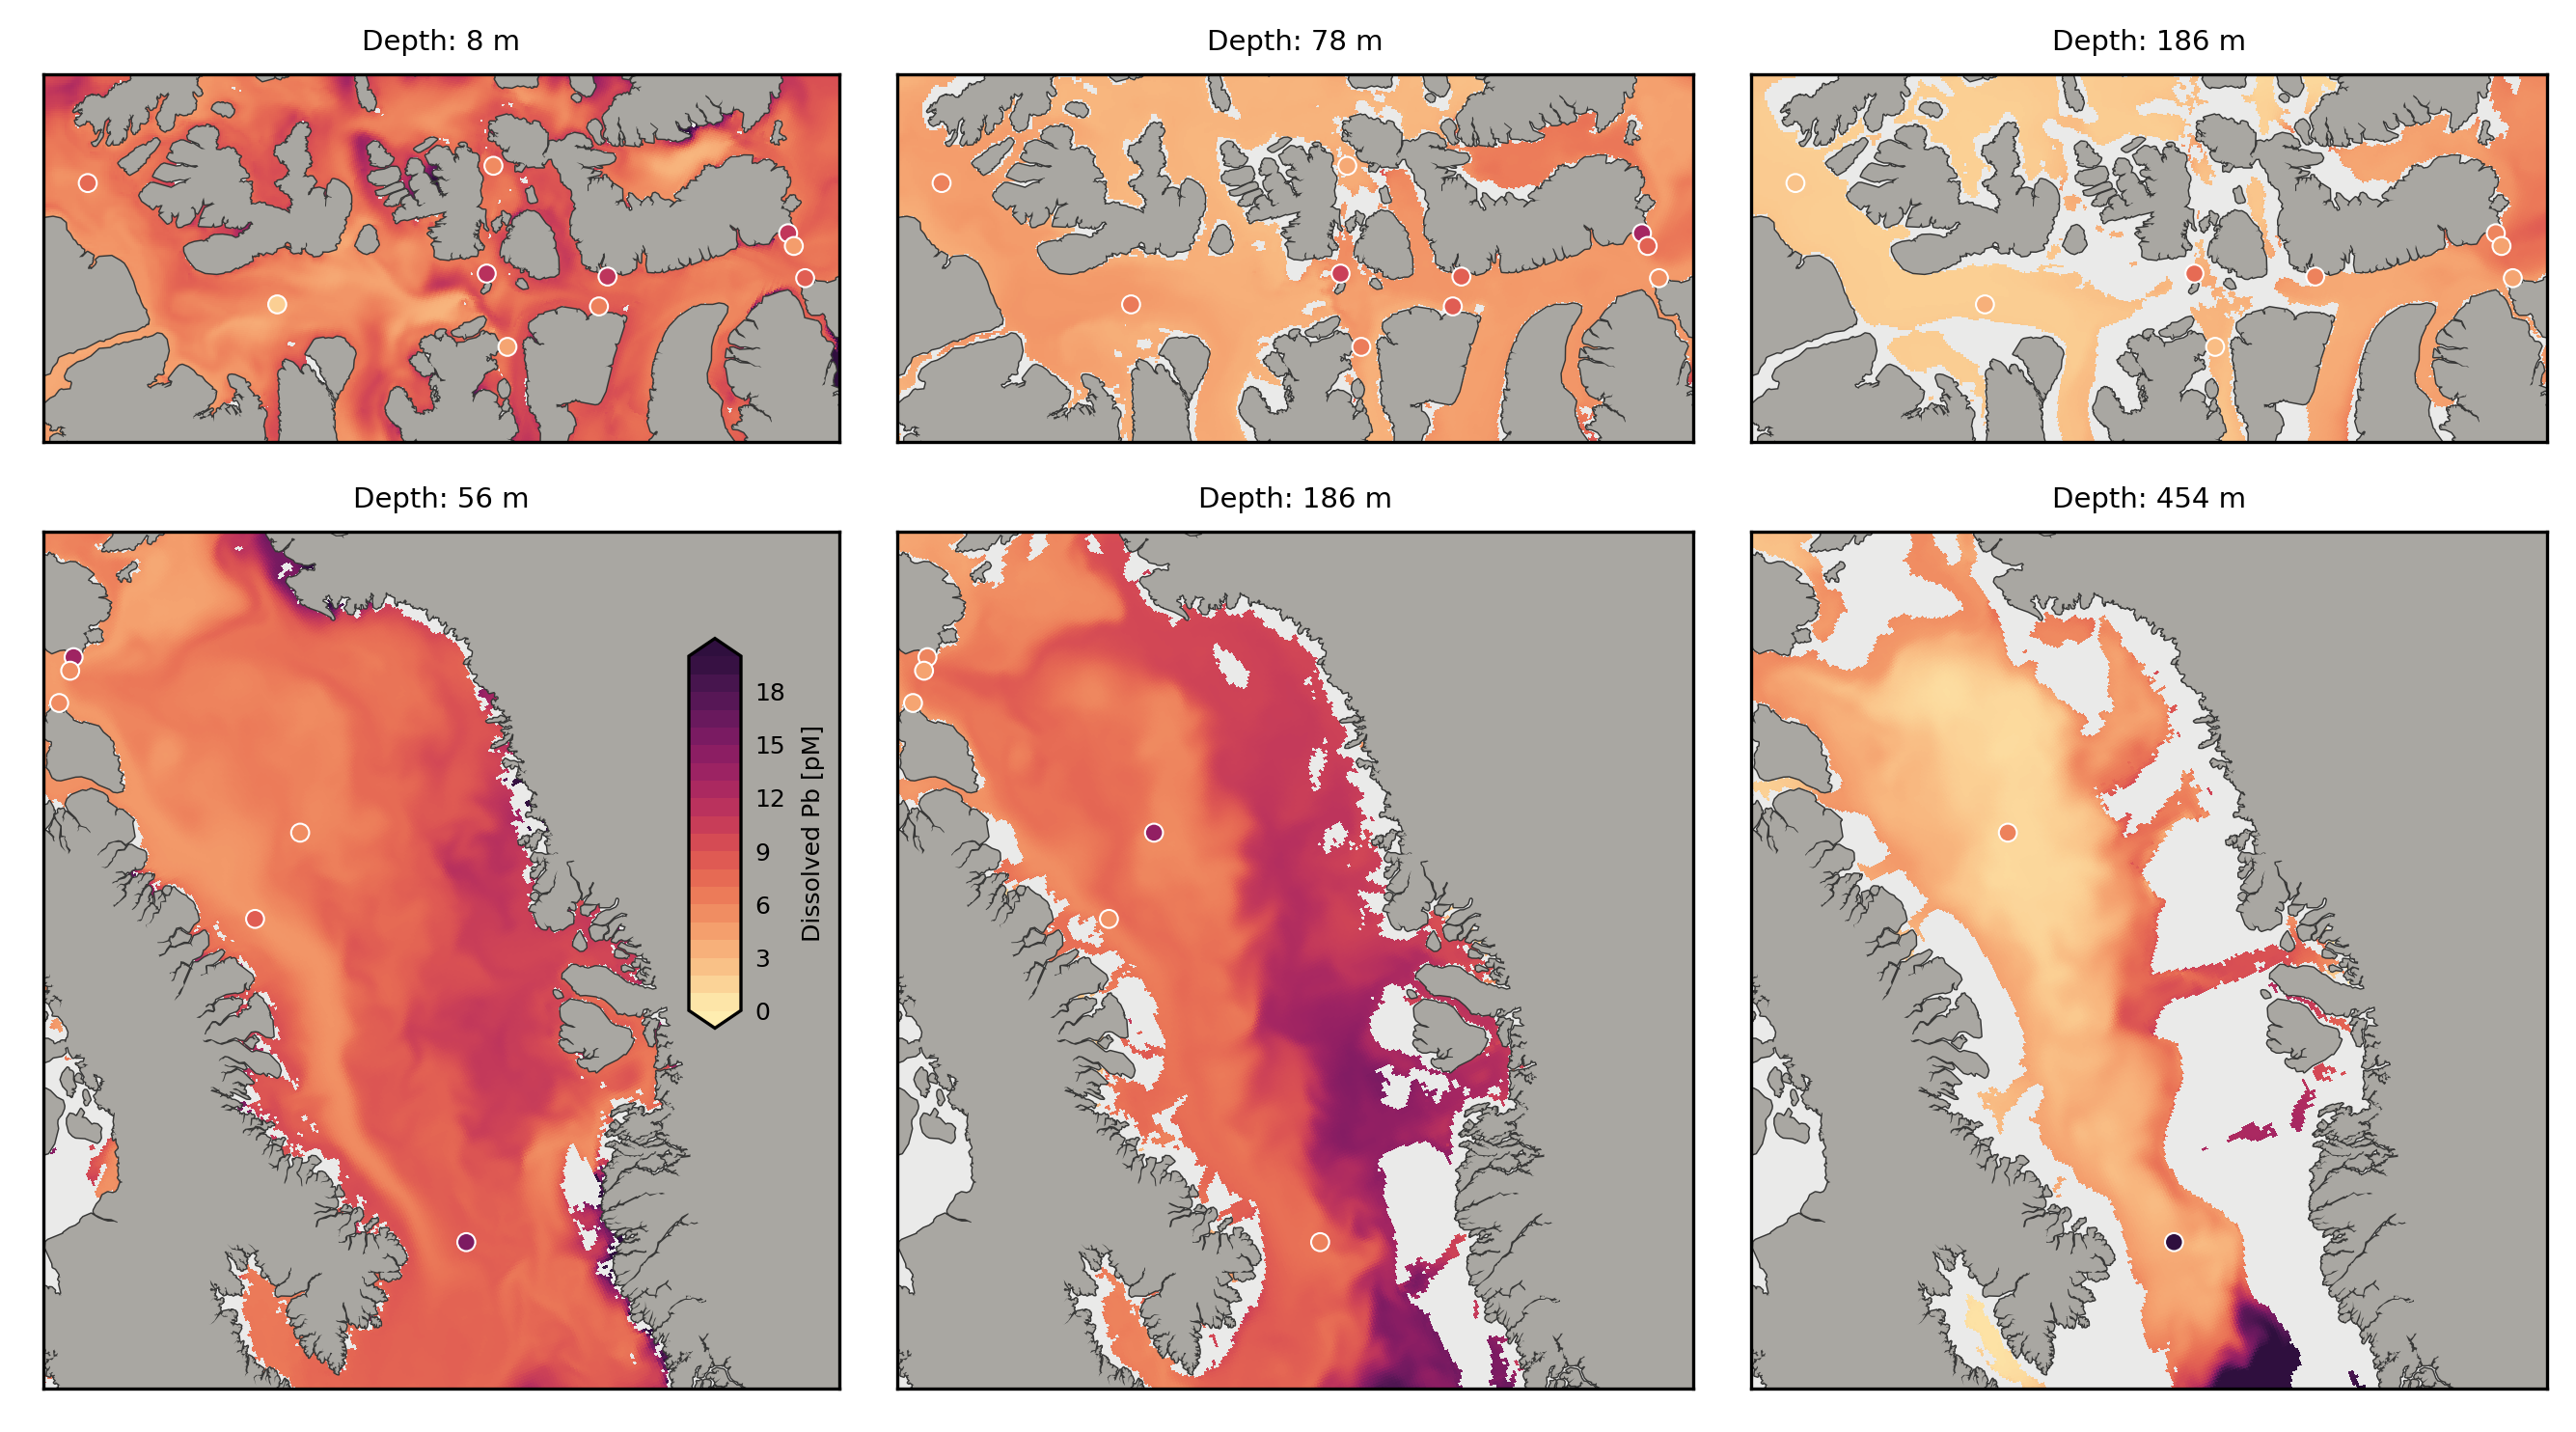

In [59]:
plot_mix(dissolpb, (6,20,25), (18,25,30), vmin=0, vmax=20, savefig=False, obs=True)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


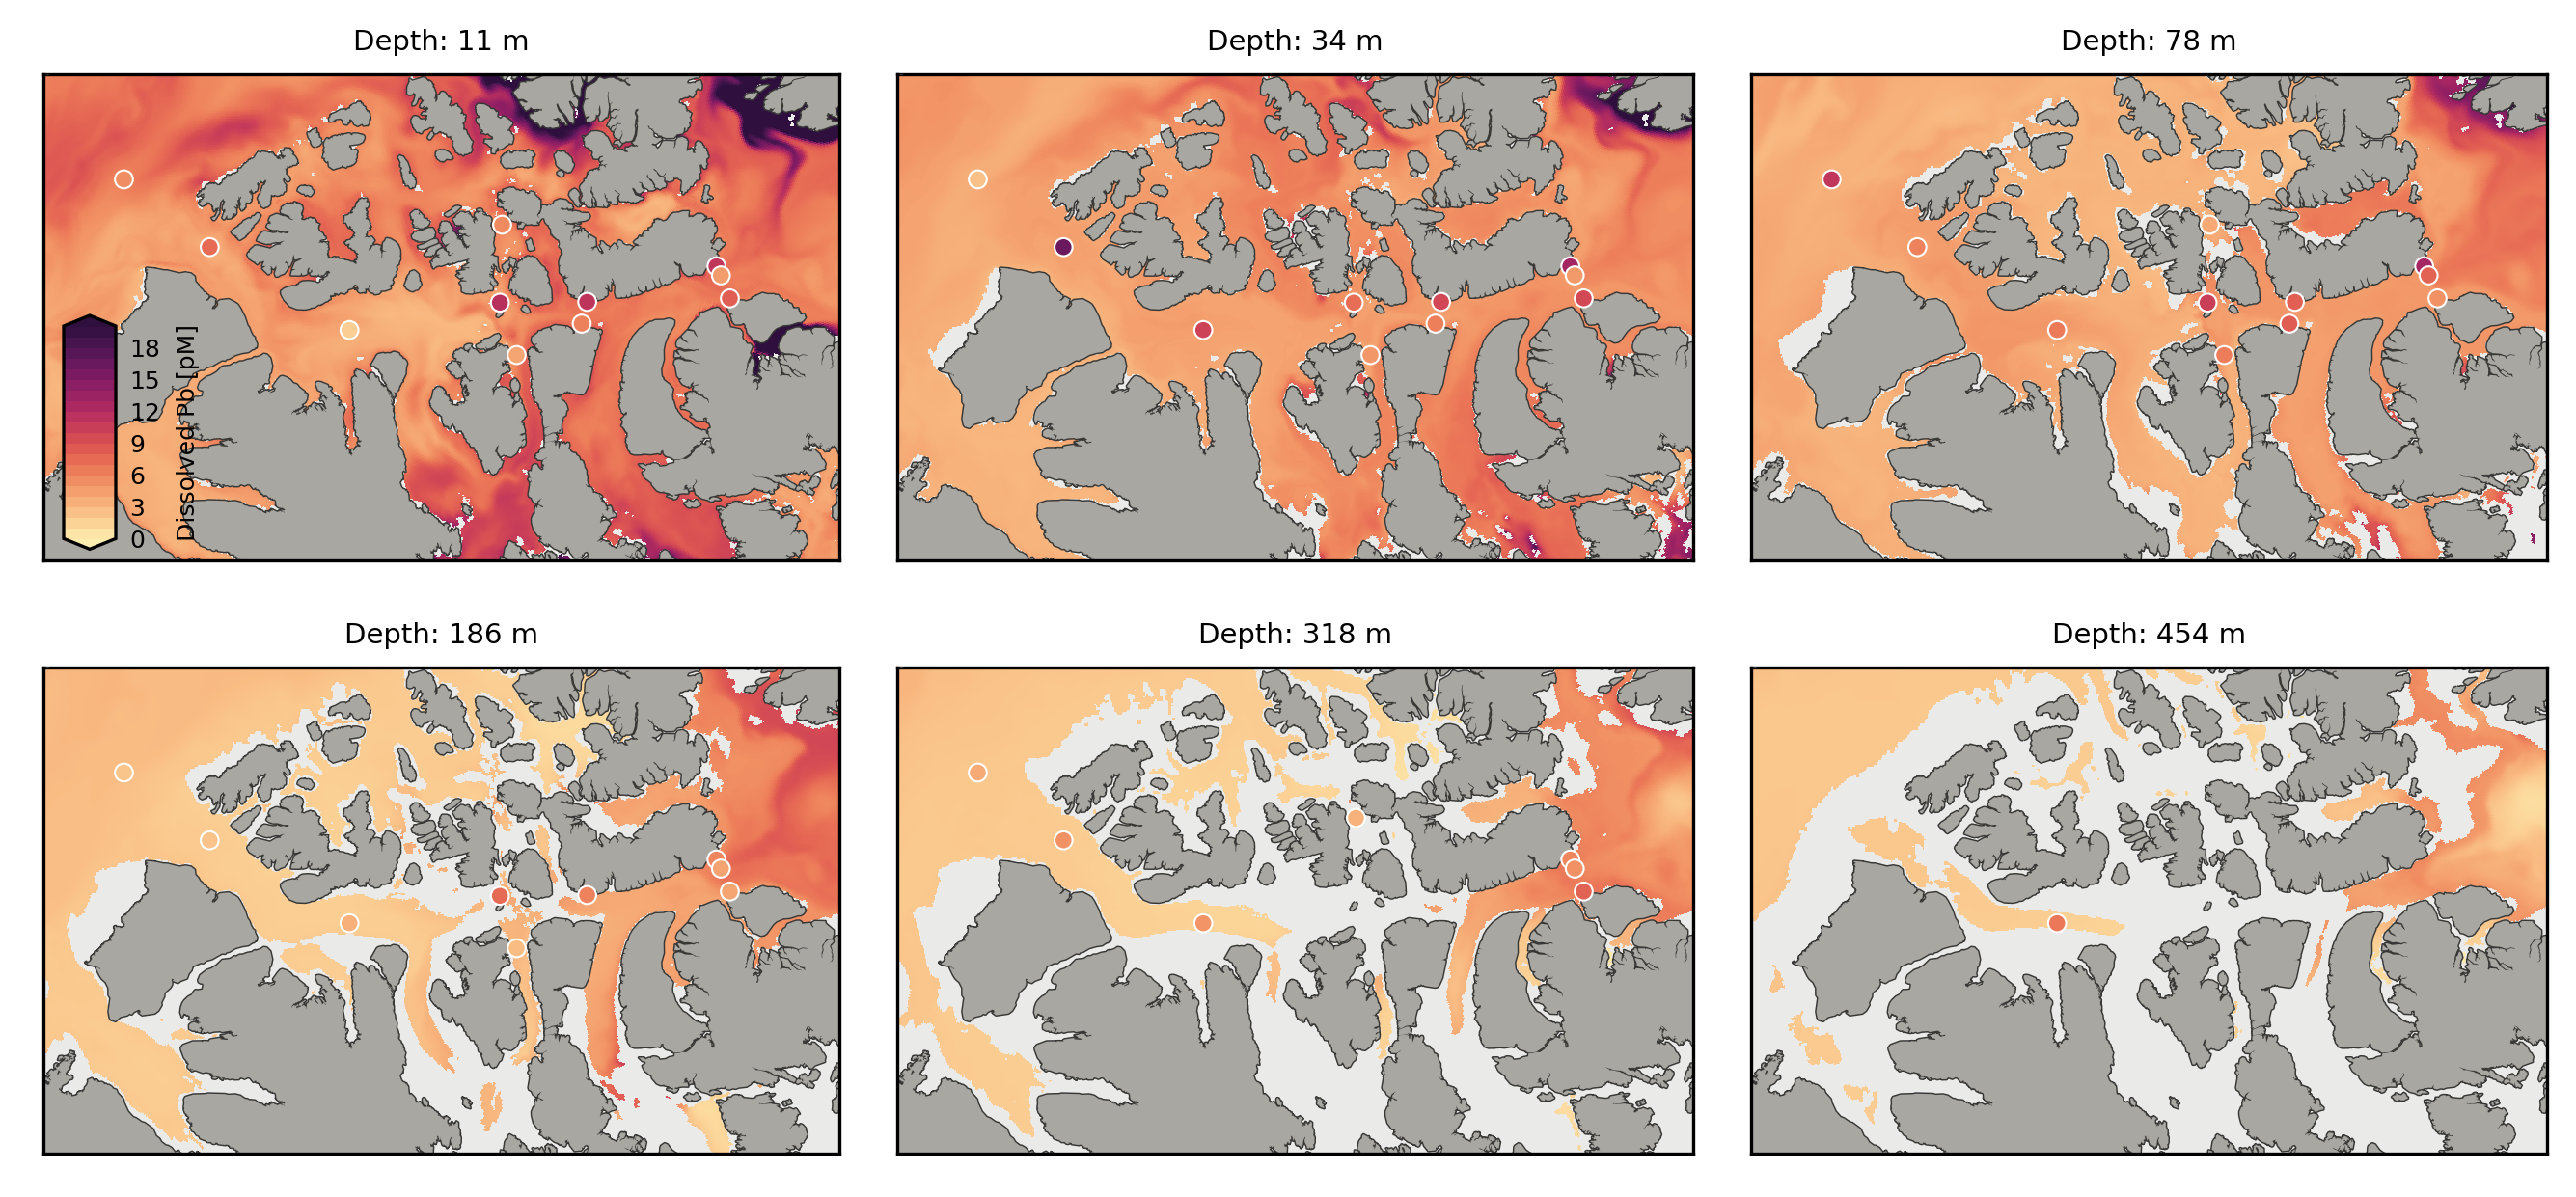

In [17]:
plot_parry_channel(dissolpb, (8,15,20,25,28,30), vmin=0, vmax=20, savefig=False, obs=True)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


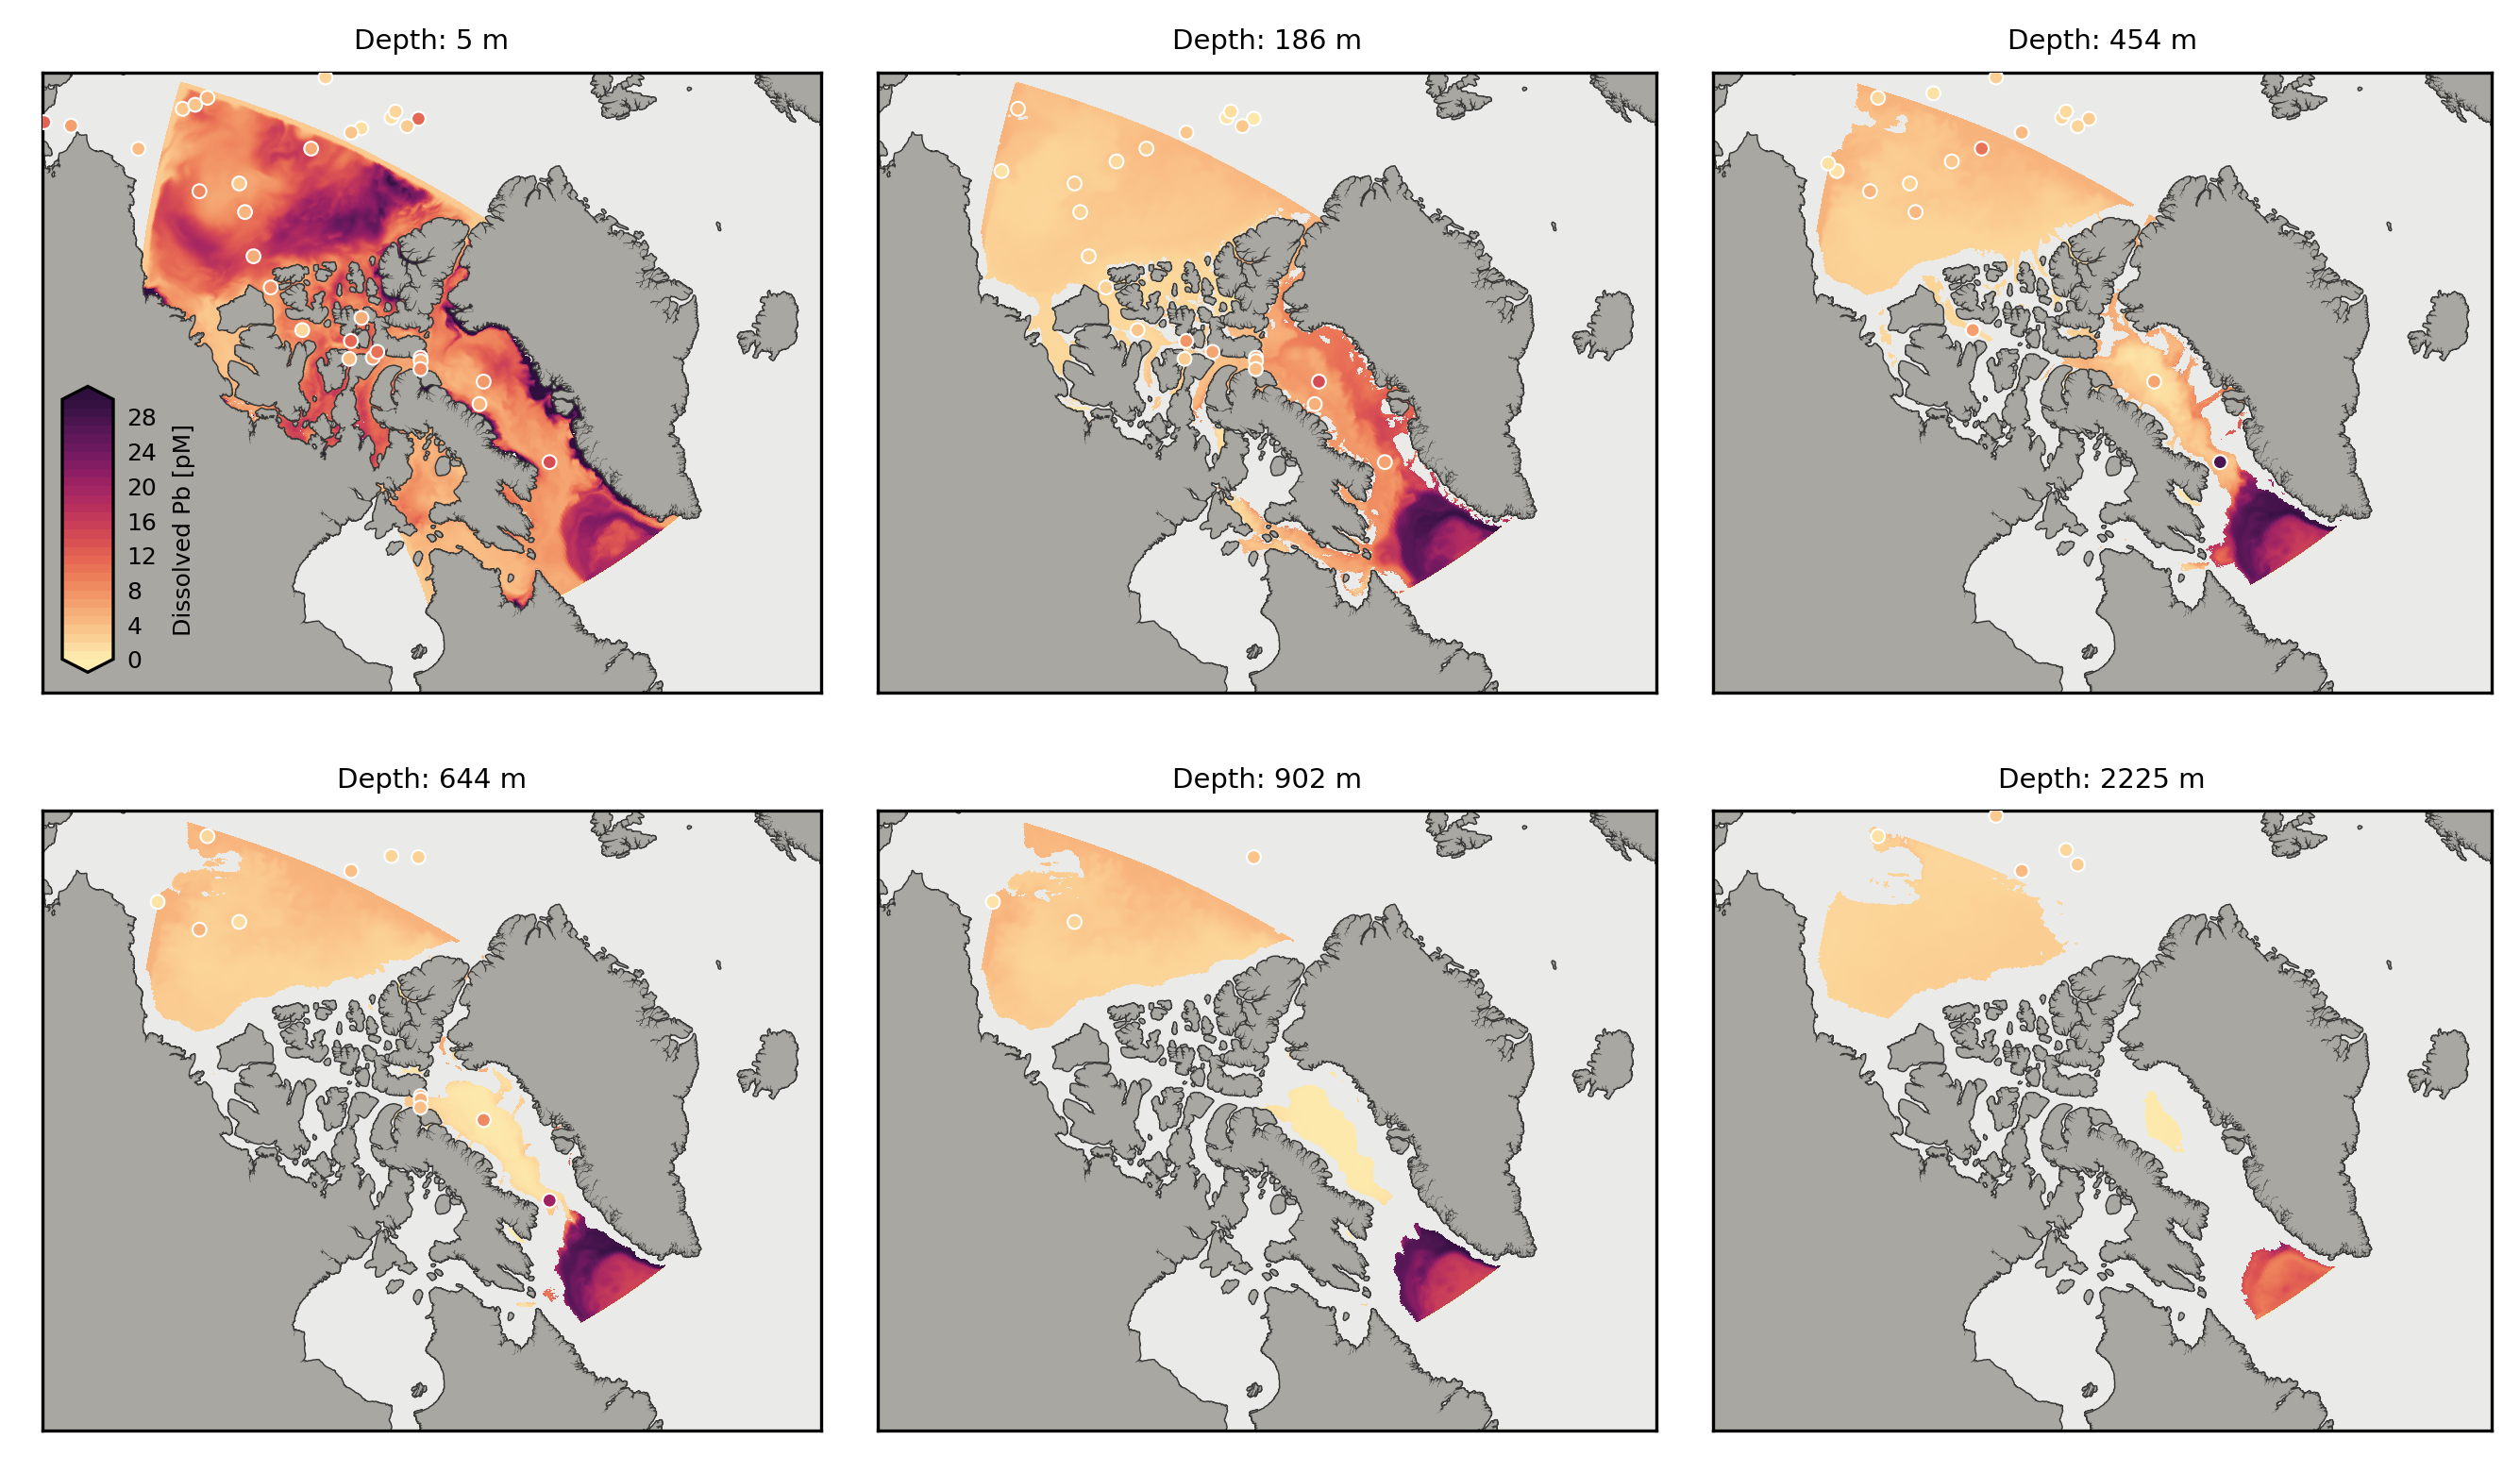

In [9]:
plot_grid_layers(dissolpb, (4,25,30,32,34,40), vmin=0, vmax=30, savefig=False, obs=True)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice


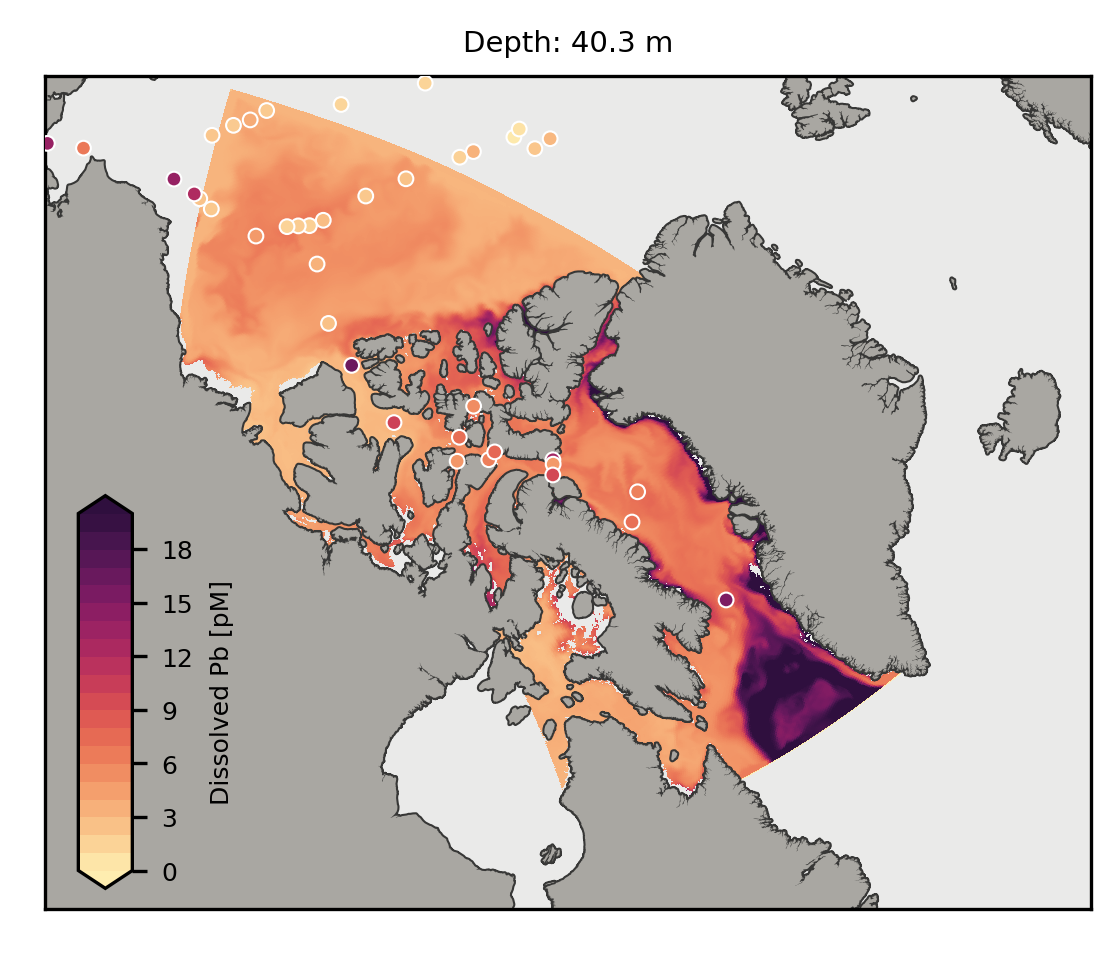

In [44]:
top = 3; bottom = 16;
plot_variable = calculate_depth_weighted(dissolpb, levels=(top,bottom))
plot_layer(plot_variable, bottom, vmin=0, vmax=20, savefig=False, obs=True)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice


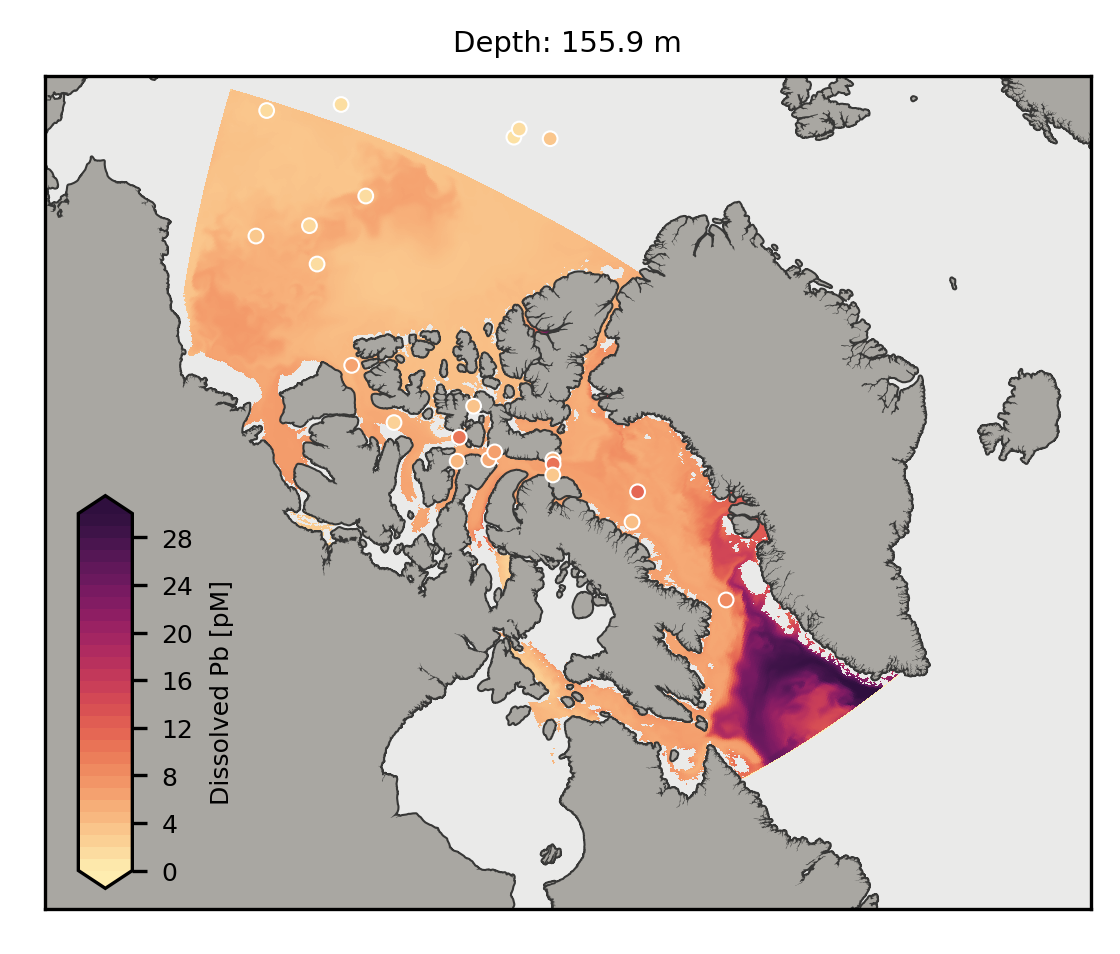

In [31]:
top = 23; bottom = 24;
plot_variable = calculate_depth_weighted(dissolpb, levels=(top,bottom))
plot_layer(plot_variable, bottom, vmin=0, vmax=30, savefig=False, obs=True)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice


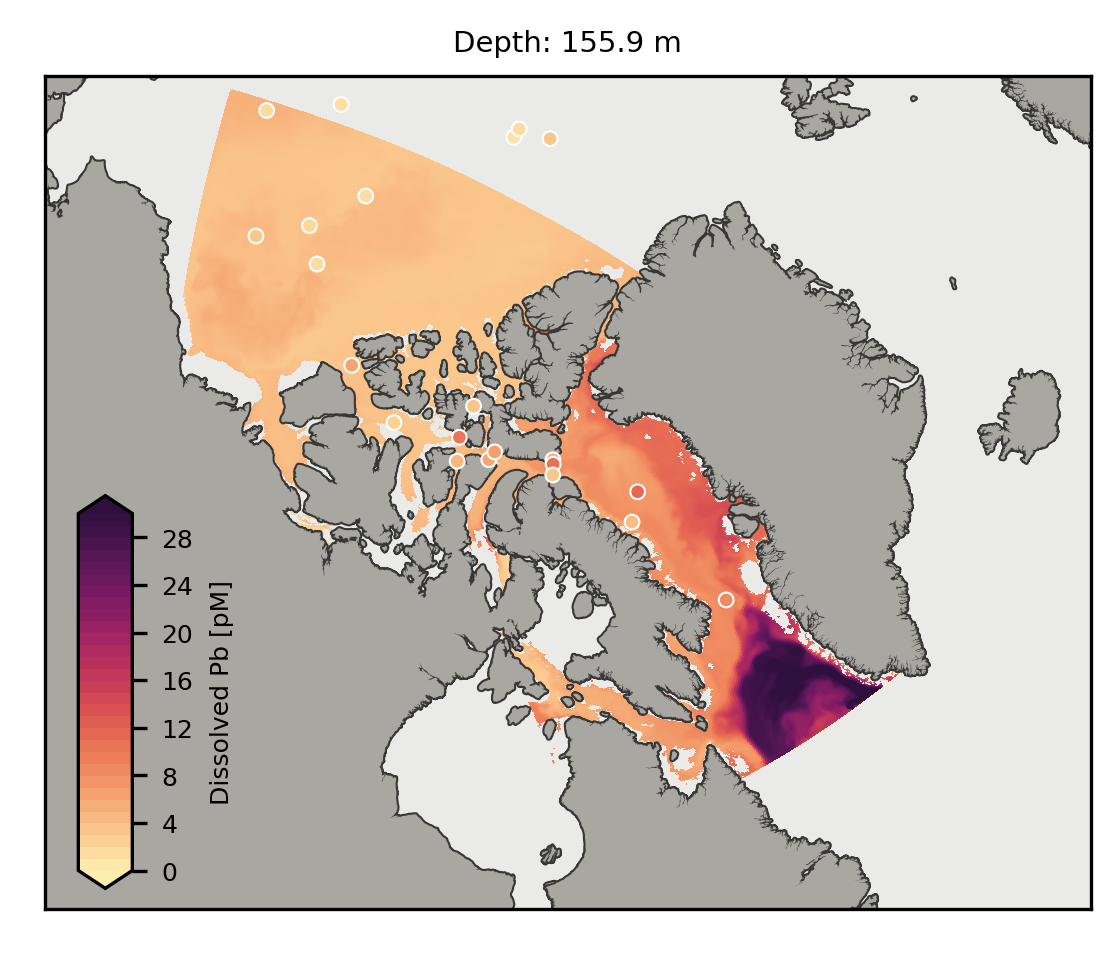

In [12]:
top = 23; bottom = 24;
plot_variable = calculate_depth_weighted(dissolpb, levels=(top,bottom))
plot_layer(plot_variable, bottom, vmin=0, vmax=30, savefig=False, obs=True)